# IY011 Baseline Model Training

Imrprovement from the ``IY011_contrastive_learning_model_training_1.ipynb``:
- File splitting and selection first

In [6]:
import os
import subprocess
import glob
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import time
# plotting 
import matplotlib.pyplot as plt
from visualisation.plots import plot_mRNA_dist, plot_mRNA_trajectory
# ml
import torch, itertools
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from models.transformer import TransformerClassifier
from training.eval import evaluate_model
from training.train import train_model 

# data handling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.data_loader import baseline_data_prep, BaselineDataset

import wandb
%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# TRAJ_PATH = [DATA_ROOT / f"mRNA_trajectories_mu{row['mu_target']:.3f}_cv{row['cv_target']:.3f}_tac{row['t_ac_target']:.3f}.csv" for idx, row in df_params.iterrows()] # the trajectories 
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

# extract meta data
parameter_sets = [{
    'sigma_b': row['sigma_b'],
    'sigma_u': row['sigma_u'],
    'rho': row['rho'],
    'd': row['d'],
    'label': 0
} for idx, row in df_params.iterrows()]
time_points = np.arange(0, 3000, 1.0)
size = 1000

In [8]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
num_groups_train=200  
num_groups_val=num_groups_train // 10
num_groups_test=num_groups_train // 10
num_traj=5
train_loader, val_loader, test_loader, scaler = baseline_data_prep(
    TRAJ_NPZ_PATH,
    batch_size=batch_size,
    num_groups_train=num_groups_train,
    num_groups_val=num_groups_val,
    num_groups_test=num_groups_test,
    num_traj=num_traj,
)
# === Dataloader hyperparams & data prep ===

Files split: 655 Train, 164 Val, 205 Test
Generating 200 training groups...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Generating validation groups...


100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


Generating test groups...


100%|██████████| 20/20 [00:03<00:00,  6.32it/s]

Fitting StandardScaler on training data...


## Visualise Data and Check Shapes

In [9]:
X_b, y_b = next(iter(train_loader))
print(X_b.shape, y_b.shape) # (Batch, Seq_Len, num_traj), (Batch, 1)

torch.Size([64, 1811, 5]) torch.Size([64, 1])


Batch Summary - Batch Size: 64
  Positive Samples (Label 1): 31
  Negative Samples (Label 0): 33
  Channels per Sample (num_traj): 10


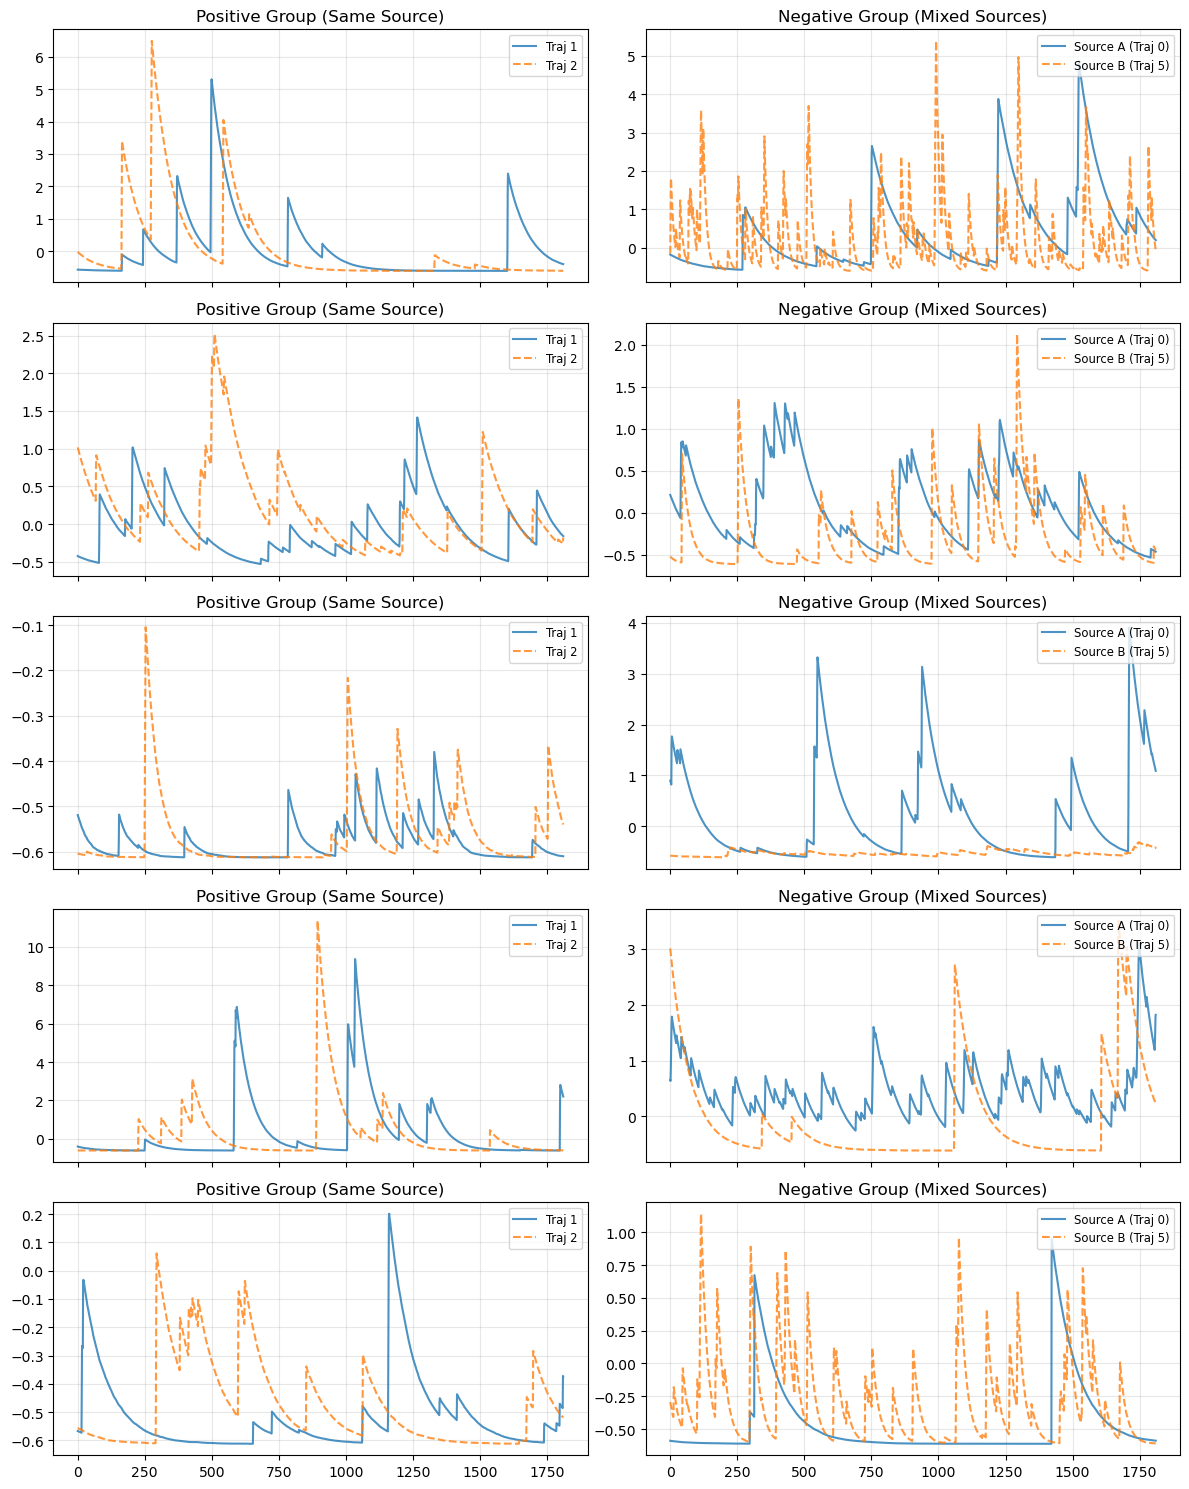

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_loader_pairs(loader, num_to_plot=3):
    """
    Visualizes Positive and Negative inputs from the DataLoader.
    Handles cases where input has > 2 channels (num_traj > 2).
    """
    # 1. Get a single batch
    batch = next(iter(loader))
    X_tensor, y_tensor = batch
    
    # X shape: (Batch, Time, Channels/num_traj)
    # y shape: (Batch, 1)
    
    # Move to CPU/Numpy
    X = X_tensor.cpu().numpy()
    y = y_tensor.cpu().numpy().flatten()
    
    num_channels = X.shape[2]
    
    # 2. Separate Indices by Label
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]
    
    print(f"Batch Summary - Batch Size: {len(y)}")
    print(f"  Positive Samples (Label 1): {len(pos_indices)}")
    print(f"  Negative Samples (Label 0): {len(neg_indices)}")
    print(f"  Channels per Sample (num_traj): {num_channels}")

    # 3. Plotting Setup
    fig, axes = plt.subplots(num_to_plot, 2, figsize=(12, 3 * num_to_plot), sharex=True)
    if num_to_plot == 1: axes = axes.reshape(1, -1) # Handle 1 row case

    # --- Plot Positives (Left Column) ---
    for i in range(num_to_plot):
        ax = axes[i, 0]
        if i < len(pos_indices):
            idx = pos_indices[i]
            # For Positive, all channels are from same source. 
            # We plot the first two channels to show similarity within the group.
            ax.plot(X[idx, :, 0], label=f'Traj 1', alpha=0.8)
            ax.plot(X[idx, :, 1], label=f'Traj 2', alpha=0.8, linestyle='--')
            ax.set_title(f"Positive Group (Same Source)")
            ax.legend(loc='upper right', fontsize='small')
        ax.grid(True, alpha=0.3)

    # --- Plot Negatives (Right Column) ---
    for i in range(num_to_plot):
        ax = axes[i, 1]
        if i < len(neg_indices):
            idx = neg_indices[i]
            # For Negative, channels are split. 
            # First half = Source A, Second half = Source B.
            split_idx = num_channels // 2
            
            # Plot one from Source A (Channel 0)
            ax.plot(X[idx, :, 0], label=f'Source A (Traj 0)', alpha=0.8)
            # Plot one from Source B (Channel split_idx)
            ax.plot(X[idx, :, split_idx], label=f'Source B (Traj {split_idx})', alpha=0.8, linestyle='--')
            
            ax.set_title(f"Negative Group (Mixed Sources)")
            ax.legend(loc='upper right', fontsize='small')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
# === Usage ===
visualize_loader_pairs(train_loader, num_to_plot=5)

In [31]:
# === Model hyperparams ===
input_size = num_traj
num_classes = 2
d_model=64
nhead=4
num_layers=2
dropout=0.001
use_conv1d=False 

model = TransformerClassifier(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout, 
    use_conv1d=use_conv1d 
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 50
patience = 10
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

### schedulers ### 
# 1. simple scheduler choice
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
# total_steps = epochs * len(train_loader)
# warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
# from transformers import get_cosine_schedule_with_warmup
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps,
# ) 

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = 1.0
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===

TransformerClassifier(
  (input_proj): Linear(in_features=10, out_features=64, bias=True)
  (pe): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.001, inplace=False)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY011-baseline-model",
    "name": f"num_groups_train_{num_groups_train}_traj_{num_traj}_batch_size_{batch_size}", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_group": num_traj,
    "num_groups_train": num_groups_train,
    "num_groups_val": num_groups_val,
    "num_groups_test": num_groups_test,
}
# === wandb config === 

In [33]:
from training.train import train_model
history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    wandb_logging=True, # this enables wandb logging within train_model
    wandb_config=wandb_config, # pass the config dictionary
)

wandb: Currently logged in as: grignardreagent (grignard-reagent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training...
Epoch [1/50] | train_loss 1.4169 | train_acc 0.4600 | val_loss 0.7217 | val_acc 0.5500
No improvement (1/10).
Epoch [2/50] | train_loss 0.7555 | train_acc 0.4750 | val_loss 0.6730 | val_acc 0.5500
Epoch [3/50] | train_loss 0.6828 | train_acc 0.5650 | val_loss 0.6367 | val_acc 0.6000
No improvement (1/10).
Epoch [4/50] | train_loss 0.6185 | train_acc 0.6350 | val_loss 0.5845 | val_acc 0.6000
No improvement (2/10).
Epoch [5/50] | train_loss 0.5639 | train_acc 0.6800 | val_loss 0.6181 | val_acc 0.5500
Epoch [6/50] | train_loss 0.5758 | train_acc 0.6850 | val_loss 0.5710 | val_acc 0.6500
No improvement (1/10).
Epoch [7/50] | train_loss 0.4943 | train_acc 0.7600 | val_loss 0.6052 | val_acc 0.6000
No improvement (2/10).
Epoch [8/50] | train_loss 0.5890 | train_acc 0.6150 | val_loss 0.5311 | val_acc 0.6000
Epoch [9/50] | train_loss 0.4808 | train_acc 0.7350 | val_loss 0.6109 | val_acc 0.7500
No improvement (1/10).
Epoch [10/50] | train_loss 0.4984 | train_acc 0.7550 | val

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
grad/norm,████████████████████▇███▁█▃
lr,████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▁▂▃▄▄▅▃▅▅▆▆▆▆▆▇▇▇▇████████
train/loss,█▄▄▄▃▃▃▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/acc,▁▁▂▂▁▄▂▂▇▄▄▂▅▅▇▇▇██▇██▇▇▇██
val/loss,█▇▆▄▅▄▅▃▅▄▂▄▄▂▂▂▂▁▁▁▂▂▃▃▃▃▃
best_val_acc,0.8
epoch,27
grad/norm,0.48891
lr,0.00016


Training complete.


## Save Model

In [34]:
# save the trained model
model_path = 'baseline_transformer_model.pth'
torch.save(model.state_dict(), model_path)

## Eval: test_loader

In [52]:
# evaluate on test set
test_loss, test_acc = evaluate_model(
    model,
    test_loader,
    loss_fn,
    device,
)

Test — loss: 1.20 | acc: 0.65


## Eval: unseen data

In [24]:
from simulation.mean_cv_t_ac import find_tilda_parameters
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model

# ==========================================
# 1. GENERATE UNSEEN DATA
# ==========================================
def generate_unseen_classes(n_classes=5, n_trajs_per_class=20, seq_len=3000):
    """
    Generates N new 'mystery' datasets with random parameters.
    Returns a list of dictionaries, each representing a unique biological condition.
    """
    print(f"Generating {n_classes} unseen classes...")
    unseen_data = []
    
    # Randomly sample parameters (Mu, CV, Tac)
    # We pick ranges similar to your training data to ensure they are valid biological possibilities
    mus = np.random.uniform(10, 100, n_classes)
    cvs = np.random.uniform(0.5, 2.0, n_classes)
    tacs = np.random.uniform(5, 50, n_classes)
    
    time_points = np.arange(0, seq_len, 1.0)

    for i in range(n_classes):
        try:
            # 1. Solve for physical parameters
            rho, d, sigma_b, sigma_u = find_tilda_parameters(mus[i], tacs[i], cvs[i])
            
            # 2. Simulate
            params = [{"sigma_b": sigma_b, "sigma_u": sigma_u, "rho": rho, "d": d, "label": 0}]
            df = simulate_telegraph_model(params, time_points, n_trajs_per_class)
            
            # 3. Extract clean array (N_trajs, Time)
            # Assuming format: columns t_0...t_T, rows are trajectories
            # Adjust filtering based on your exact df structure
            trajs = df.drop(columns=['label'], errors='ignore').values
            
            unseen_data.append({
                "class_id": f"Mystery_Class_{i}",
                "parameters": {"mu": mus[i], "cv": cvs[i], "tac": tacs[i]},
                "trajectories": trajs
            })
            print(f"  Generated Class {i}: Mu={mus[i]:.1f}, CV={cvs[i]:.2f}")
            
        except Exception as e:
            print(f"  Skipped a class due to solver error: {e}")
            
    return unseen_data

# === RUN GENERATION ===
unseen_datasets = generate_unseen_classes(n_classes=5, n_trajs_per_class=20)

Generating 5 unseen classes...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Initializing Julia environment...


  Activating project at `~/stochastic_simulations/julia`


Using 12 threads for Julia simulation..
  Generated Class 0: Mu=31.5, CV=1.80
Using 12 threads for Julia simulation..
  Generated Class 1: Mu=63.4, CV=1.34
Using 12 threads for Julia simulation..
  Generated Class 2: Mu=23.3, CV=0.71
Using 12 threads for Julia simulation..
  Generated Class 3: Mu=44.7, CV=0.68
Using 12 threads for Julia simulation..
  Generated Class 4: Mu=89.9, CV=1.84


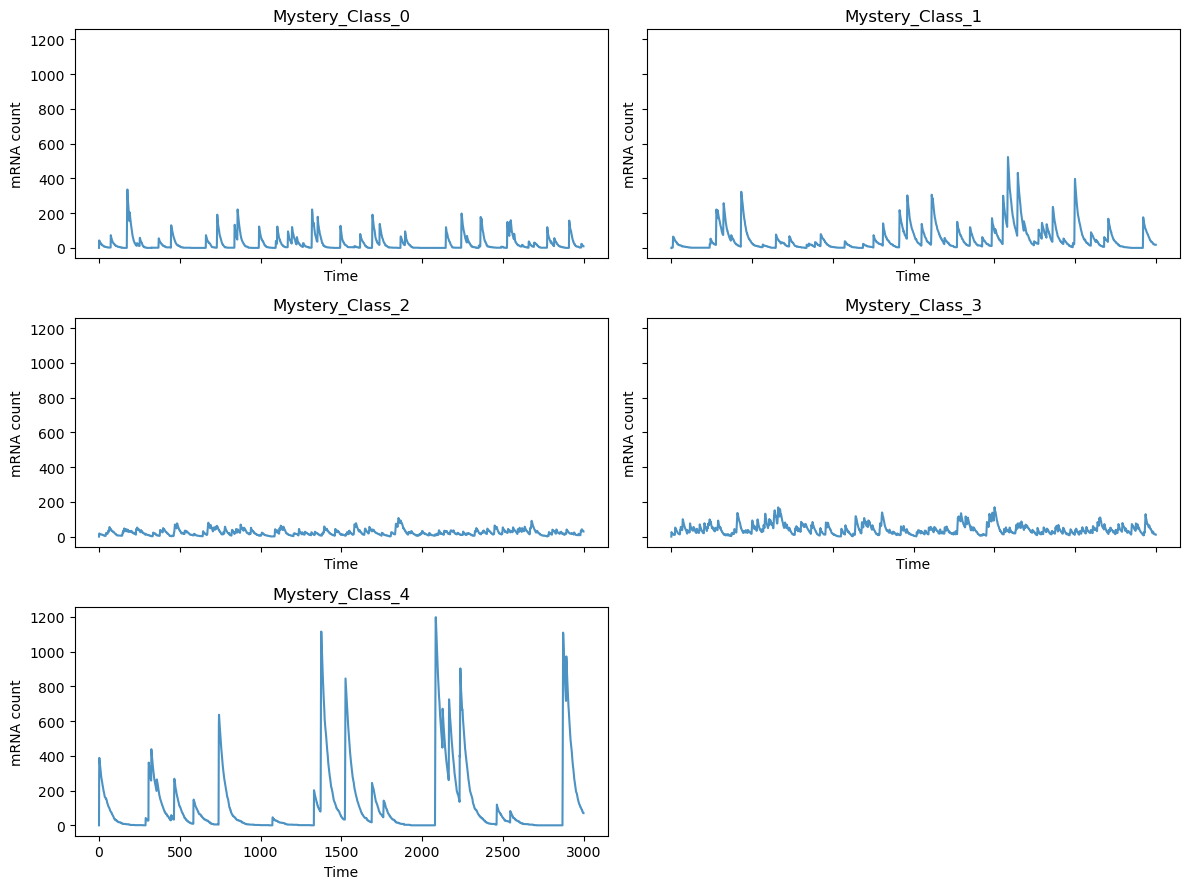

In [38]:
# subplot each unseen class separately to reduce crowding
n = len(unseen_datasets)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, unseen in enumerate(unseen_datasets):
    traj = unseen['trajectories'][0, :]
    t = time_points[:traj.shape[0]]
    axes[i].plot(t, traj, alpha=0.8)
    axes[i].set_title(unseen['class_id'])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('mRNA count')

# hide any extra subplots
for j in range(n, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [40]:
# ==========================================
# 2. EVALUATE BASELINE MODEL
# ==========================================
def test_baseline_performance(model, unseen_data, scaler, num_traj, crop_len=1811, samples_per_class=50):
    """
    Tests the Baseline Model on unseen classes using Feature Distance.
    
    Args:
        model: Trained Transformer.
        unseen_data: List of dicts with 'trajectories' (raw numpy arrays).
        scaler: Fitted StandardScaler.
        num_traj: The 'input_size' or number of channels the model expects.
        samples_per_class: How many random groups to test per class.
    """
    model.eval()
    device = next(model.parameters()).device
    
    correct = 0
    total_queries = 0
    
    print(f"\n=== Testing Baseline Model (Feature Distance) ===")
    print(f"Model expects groups of {num_traj} trajectories.")
    
    # --- Phase 1: Build Reference Embeddings (Prototypes) ---
    class_prototypes = {}
    
    for data in unseen_data:
        pool = data['trajectories']
        
        # We use a larger chunk of the pool to define the "Class Prototype"
        # Let's sample 5 random groups of size `num_traj` and average their embeddings
        ref_embeddings = []
        
        for _ in range(5):
            # 1. Sample a group
            indices = np.random.choice(len(pool), num_traj, replace=True)
            group = pool[indices] # (num_traj, Time)
            
            # 2. Transpose to (Time, num_traj) for scaling logic if needed
            # But typically scaler expects (N_samples, 1). 
            # Let's scale flattened then reshape to (1, Time, num_traj) for model.
            
            # Flatten -> Scale -> Reshape
            T = min(group.shape[1], crop_len)
            group_crop = group[:, :T]
            
            # Reshape for scaler: (num_traj * T, 1)
            flat = group_crop.reshape(-1, 1)
            scaled = scaler.transform(flat).reshape(num_traj, T)
            
            # Prepare Tensor: (1, T, num_traj) -> Batch size 1
            # Note: The model expects (Batch, Time, Channels)
            tensor_in = torch.tensor(scaled.T, dtype=torch.float32).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # Get embedding (N, d_model)
                emb = model.encode(tensor_in).cpu().numpy()
                ref_embeddings.append(emb)
        
        # Average to get class prototype
        class_prototypes[data['class_id']] = np.mean(ref_embeddings, axis=0).flatten()
        
    print(f"✅ Built prototypes for {len(class_prototypes)} classes.")

    # --- Phase 2: Query / Classification ---
    for data in unseen_data:
        true_class = data['class_id']
        pool = data['trajectories']
        
        # Generate random query groups
        for _ in range(samples_per_class):
            # 1. Sample a Query Group
            indices = np.random.choice(len(pool), num_traj, replace=True)
            query_group = pool[indices]
            
            # 2. Preprocess
            T = min(query_group.shape[1], crop_len)
            query_crop = query_group[:, :T]
            
            flat = query_crop.reshape(-1, 1)
            scaled = scaler.transform(flat).reshape(num_traj, T)
            
            # Shape: (1, T, num_traj)
            tensor_in = torch.tensor(scaled.T, dtype=torch.float32).unsqueeze(0).to(device)
            
            # 3. Get Query Feature
            with torch.no_grad():
                query_vec = model.encode(tensor_in).cpu().numpy().flatten()
            
            # 4. Compare to Prototypes (Euclidean Dist)
            best_dist = float('inf')
            predicted = None
            
            for cls_id, proto in class_prototypes.items():
                dist = np.linalg.norm(query_vec - proto)
                if dist < best_dist:
                    best_dist = dist
                    predicted = cls_id
            
            if predicted == true_class:
                correct += 1
            total_queries += 1

    acc = correct / total_queries if total_queries > 0 else 0
    print(f"Baseline One-Shot Accuracy: {acc:.2%}")
    return acc

In [49]:
acc = test_baseline_performance(model, unseen_datasets, scaler, num_traj=num_traj)


=== Testing Baseline Model (Feature Distance) ===
Model expects groups of 10 trajectories.
✅ Built prototypes for 5 classes.
Baseline One-Shot Accuracy: 41.20%


## SVM Benchmark

In [50]:
def extract_data_for_svm(loader):
    """
    Extracts all batches from a DataLoader and flattens them for SVM input.
    Input X: (Batch, Time, Features) -> Output X: (Total_Samples, Time * Features)
    """
    X_list = []
    y_list = []
    
    print(f"Extracting data from loader for SVM...")
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Move to CPU and convert to numpy
            X_np = X_batch.cpu().numpy()
            y_np = y_batch.cpu().numpy()
            
            # Flatten the time series: 
            # (Batch, Seq_Len, 1) -> (Batch, Seq_Len)
            # This turns the time series into a long feature vector
            X_flat = X_np.reshape(X_np.shape[0], -1)
            
            X_list.append(X_flat)
            y_list.append(y_np)
            
    # Concatenate all batches
    return np.vstack(X_list), np.concatenate(y_list)

In [51]:
from classifiers.svm_classifier import svm_classifier

# 1. Extract Data dynamically from your loaders
X_train_svm, y_train_svm = extract_data_for_svm(train_loader)
X_test_svm, y_test_svm   = extract_data_for_svm(test_loader)

print(f"SVM Train Shape: {X_train_svm.shape}")
print(f"SVM Test Shape:  {X_test_svm.shape}")

# 2. Run the SVM Classifier
svm_accuracy = svm_classifier(
    X_train_svm,
    X_test_svm,
    y_train_svm,
    y_test_svm,
)

Extracting data from loader for SVM...
Extracting data from loader for SVM...
SVM Train Shape: (200, 18110)
SVM Test Shape:  (20, 18110)


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== SVM (RBF Kernel) Classification Accuracy: 0.55 ===


## Permutation Test

In [53]:
import torch
import numpy as np

def run_permutation_test(model, test_loader, device='cpu'):
    """
    Evaluates the model on:
    1. Original Data (Preserves Temporal Patterns)
    2. Shuffled Data (Destroys Temporal Patterns, Preserves Stats)
    
    This determines if the model is learning "physics" (dynamics) or just "identity" (mean intensity).
    """
    model.eval()
    model.to(device)
    
    correct_original = 0
    correct_shuffled = 0
    total = 0
    
    print("Running Permutation Test...")
    
    with torch.no_grad():
        for X, y in test_loader:
            # Move to device
            X = X.to(device)
            y = y.to(device).squeeze() # Fix: Flatten y from (B, 1) to (B)
            
            # --- Helper to get predictions ---
            def get_preds(logits):
                if logits.shape[1] > 1:
                    # Multi-class (e.g. 2 output nodes for Pos/Neg)
                    return torch.argmax(logits, dim=1)
                else:
                    # Binary (1 output node + Sigmoid)
                    return (torch.sigmoid(logits) > 0.5).float().squeeze()

            # --- 1. Test on ORIGINAL (Ordered) ---
            logits_orig = model(X)
            preds_orig = get_preds(logits_orig)
            correct_original += (preds_orig == y).sum().item()
            
            # --- 2. Test on SHUFFLED (Scrambled) ---
            # We shuffle the time dimension (axis 1) for each sample independently
            # This breaks temporal dependency but keeps mean/variance identical.
            X_shuffled = X.clone()
            B, T, C = X.shape
            
            for i in range(B):
                idx = torch.randperm(T)
                X_shuffled[i] = X[i, idx, :] # Shuffle time, keep channels aligned
            
            logits_shuff = model(X_shuffled)
            preds_shuff = get_preds(logits_shuff)
            correct_shuffled += (preds_shuff == y).sum().item()
            
            total += B
    
    # Calculate Final Accuracy
    acc_orig = correct_original / total
    acc_shuff = correct_shuffled / total
    
    print(f"------------------------------------------------")
    print(f"Accuracy on ORIGINAL Data:  {acc_orig:.2%}")
    print(f"Accuracy on SHUFFLED Data:  {acc_shuff:.2%}")
    print(f"------------------------------------------------")
    
    # The Verdict
    if acc_shuff > 0.8:
        print("🚨 VERDICT: MODEL IS CHEATING.")
        print("The model still works even when time is scrambled.")
        print("It is relying on Global Statistics (Mean/Var/Identity), not Temporal Patterns.")
    elif acc_shuff < 0.6: # Assuming balanced classes (random chance ~50%)
        print("✅ VERDICT: MODEL IS LEGIT.")
        print("The model failed when time was scrambled.")
        print("It was strictly relying on Temporal Dynamics.")
    else:
        print("⚠️ VERDICT: MIXED.")
        print("The model likely uses a mix of stats and temporal features.")
        
    return acc_orig, acc_shuff

In [54]:
# Run the test (assuming 'model' and 'test_loader' are loaded from _1.ipynb)
run_permutation_test(model, test_loader, device=device)

Running Permutation Test...
------------------------------------------------
Accuracy on ORIGINAL Data:  70.00%
Accuracy on SHUFFLED Data:  70.00%
------------------------------------------------
⚠️ VERDICT: MIXED.
The model likely uses a mix of stats and temporal features.


(0.7, 0.7)